# Filter Function Spectroscopy

Here we show how to use injected noise to extract information about the filter function (or frequency response) of a quantum system when subject to controlled evolution. As an illustrative example, we will focus on the CPMG dynamical decoupling sequence, as the filter function is well understood.

## Broad Overview of the Theory

Consider the case of a single qubit system subject to a Hamiltonian $H(t)=H_C(t)+H_S(t)$, where $H_C(t)$ describes the control Hamiltonian and $H_S(t)$ denotes what we will call the signal Hamiltonian. The control Hamiltonian can be thought of as the control operations (or gates) that are implemented in a circuit, while the signal Hamiltonian can be thought of as the noise (or signal) we inject into the circuit. With the Hamiltonian defined, consider the following experiment: prepare the qubit in the state $|\psi(0)\rangle=U_{prep}|0\rangle$, allow it to evolve according to $U(t)=\mathcal{T}_{+}e^{-i\int^{t}_{0} H(s) ds}$, and measure the state $|\psi(0)\rangle$. One can now ask the question: what is the probability of the qubit remaining in the initially prepared state? The answer is determined by calculating the survival probability

$$
F(t)=|\langle \psi(0)|U(T)|\psi(0)\rangle|^2 = |\langle 0|U^\dagger_{prep} U(t) U_{prep}|0\rangle|^2.
$$

Interestingly, without going into the math in detail, the survival probability can be approximated by the expression $F(t)\approx\frac{1}{2}(1+e^{-\chi(t)})$, where

$$
\chi(t) = \sum_\alpha \int^{\infty}_0 \frac{d\omega}{2\pi} F_\alpha(\omega,t) S_\alpha(\omega)
$$

is referred to as the decay function. In general, the decay function can be a sum of terms called overlap integrals, where each integral is a convolution between a filter function $F_\alpha(\omega,t)$ and the power spectral density (PSD) $S_\alpha(\omega)$. The PSD may represent many things, e.g., fluctuating noise processes or, in our case, an injected signal.

So, what can we do with the above expressions? It turns out that they can be used in many ways to study the noisy dynamics of a system, estimate noise PSDs when they are not well-understood (e.g., on hardware), or estimate a filter function. Obviously, the last application is most interesting to us. We are particularly interested in using the overlap integral to estimate the filter function of an F-GRAFS control waveform. We expect the control to tailor the filter function such that it possesses spectral nulls at particular locations in frequency space. Given a particular control sequence, we can use engineered $S_\alpha(\omega)$ to vary the overlap between the injected signal and $F(\omega,t)$. If the overlap is large, then the decay function will be larger; thus, resulting in a lower survival probability. 

For simplicity, assume that we only have a single $S_\alpha(\omega)=S(\omega)$. In order to "map" out the filter function $F(\omega,t)$, we will use narrow band noise such that $S(\omega)\approx A\delta(\omega-\omega_0)$. Plugging this into the decay function, we obtain

$$
\chi(t) \approx \frac{1}{2\pi} F(\omega_0,t).
$$

This result is the driving force for filter spectroscopy. Namely, narrow band noise may be used to isolate filter function contributions to the decay function at particular frequencies. By varying $\omega_0$ over some range and examining the decay function (or survival probability), we gain indirect knowledge of the filter function.

# CPMG Filter Function Spectroscopy

In [1]:
import numpy as np
import scipy.signal as si
import scipy.linalg as la
import matplotlib.pyplot as plt
import qiskit as qk
from qiskit import Aer

## Build a Circuit

First, let's build a circuit representation of CPMG using qiskit.

In [2]:
def cpmg(N, M):
    # N: Number of repetitions (cycles)
    # M: Number of identity gates for interpulse delay
    circ = qk.QuantumCircuit(1,1)
    for iN  in range(N):
        [circ.i(0) for _ in range(M)]
        circ.x(0)
        [circ.i(0) for _ in range(2*M)]
        circ.x(0)
        [circ.i(0) for _ in range(M)]
    return circ

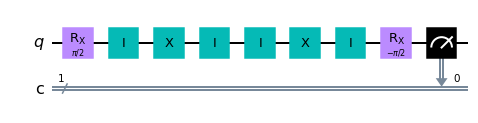

In [104]:
def cpmg_experiment(N,M):
    circ = qk.QuantumCircuit(1,1)
    circ.rx(np.pi/2,0)
    circ.compose(cpmg(1,1), inplace=True)
    circ.rx(-np.pi/2,0)
    circ.measure(0,0)
    return circ

noiseless_circ = cpmg_experiment(2,5)
noiseless_circ.draw('mpl')

## Noise Specifications

We will need to take circuits like those above and inject noise into them. In particular, we want the noise to be very narrow band so that we may probe the filter function as specific, localized frequencies.

Text(0.5, 0, 'normalized frequency')

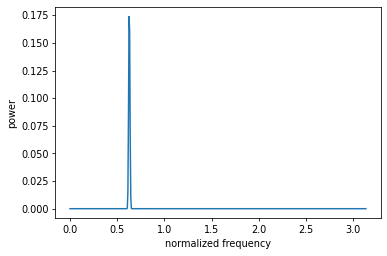

In [99]:
s_pow = 1e-3
a = [1]
NN = 512
BW = 0.001 # changes narrowness of noise spectrum
w0 = 0.2 # changes center frequency
b = si.firwin(NN, BW)*np.cos(w0*np.pi*np.arange(NN))
b = b/la.norm(b)*np.sqrt(s_pow)
w, h = si.freqz(b, a)

fig = plt.figure(dpi=70)
ax = fig.add_subplot(111)
ax.plot(w, abs(h)**2)
ax.set_ylabel('power')
ax.set_xlabel('normalized frequency')

To map out the filter function, we will vary the center frequency of the noise. An example of this is given below.

Text(0.5, 0, 'normalized frequency')

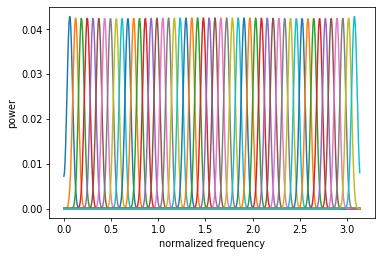

In [103]:
fig = plt.figure(dpi=70)
ax = fig.add_subplot(111)    
    
s_pow = 1e-3
a = [1]
NN = 128
BW = 0.01 # changes narrowness of noise spectrum
for w0 in np.linspace(0.02,0.98,50):
    b = si.firwin(NN, BW)*np.cos(w0*np.pi*np.arange(NN))
    b = b/la.norm(b)*np.sqrt(s_pow)
    w, h = si.freqz(b, a)    
    ax.plot(w, abs(h)**2)
ax.set_ylabel('power')
ax.set_xlabel('normalized frequency')

In [48]:
print(np.arange(NN))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]


## Circuit with Noise Injection

Now, let's create a circuit where we inject dephasing noise (noise along $\sigma_z$ or the $z$-axis of the single qubit Bloch sphere) after every gate.

In [60]:
def noisy_cpmg_experiment(N, M):
    # N: Number of repetitions (cycles)
    # M: Number of identity gates for interpulse delay
    
    tot_num_gates = N*(2 + 4*M) + 2
    x = qk.circuit.ParameterVector('x', length=tot_num_gates)
    
    circ = qk.QuantumCircuit(1,1)
    circ.rx(np.pi/2, 0)
    circ.rz(x[0], 0)
    idx = 1
    for iN  in range(N):
        for _ in range(M):
            circ.i(0)
            circ.rz(x[idx],0)
            idx += 1
        circ.x(0)
        circ.rz(x[idx],0)
        idx += 1
        for _ in range(2*M):
            circ.i(0)
            circ.rz(x[idx],0)
            idx += 1
        circ.x(0)
        circ.rz(x[idx],0)
        idx += 1
        for _ in range(M):
            circ.i(0)
            circ.rz(x[idx],0)
            idx += 1
    circ.rx(-np.pi/2, 0)
    circ.rz(x[idx],0)
    circ.measure(0,0)
    return circ, x

The probe signal PSD described above is used to create signal trajectories. Those trajectories will define the $z$-dephasing angles of rotation in the noisy circuit above.

In [61]:
def schwarma_trajectories(a, b, num_gates, num_trajectories):
    # a: coefficients of linear filter numerator
    # b: coefficients of linear filter demoninator
    # num_gates: number of gates in circuit to be "schwarmafied"
    # num_trajectories: number of noise trajectories required
    traj_list = []
    for _ in range(num_trajectories):
        angles = si.lfilter(b, a, np.random.randn(num_gates + 1000))[1000:]
        traj_list.append(angles)
    return traj_list

In [88]:
si.lfilter(b, a, np.random.randn(6 + 1000))[1000:]

array([-0.00937799,  0.00678214, -0.00500095,  0.0026288 , -0.00060702,
       -0.0014772 ])

Here is an example of the noisy circuit prior to setting a signal trajectory.

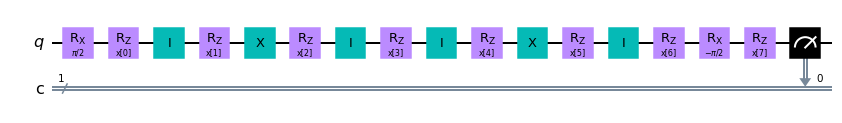

In [81]:
N, M = 1,1
num_gates = N*(2 + 4*M) + 2
noisy_exp, param_vec = noisy_cpmg_experiment(N, M)
noisy_exp.draw('mpl')

Now, we construct a set of 10 trajectories and plot the circuit for the first one only.

In [82]:
noise_traj_list = schwarma_trajectories(a, b, num_gates, 10)

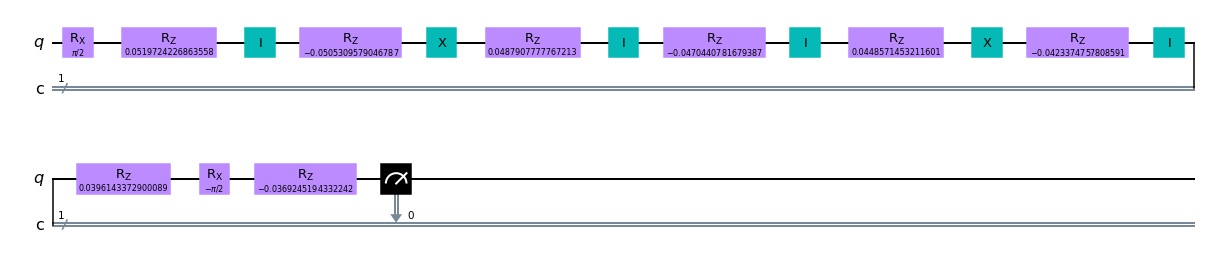

In [84]:
bound_params = {param_vec[i]: noise_traj_list[1][i] for i in range(num_gates)}
bound_circ = noisy_exp.bind_parameters(bound_params)
bound_circ.draw('mpl')

## Filter Spectroscopy Experiment

Let's now run a filter spectroscopy experiment on CPMG using the QASM simulator.

In [11]:
def generate_noise_params(s_pow, w0):
    a = [1]
    NN = 512
    BW = 0.005 # changes narrowness of noise spectrum
    b = si.firwin(NN, BW)*np.cos(w0*np.pi*np.arange(NN))
    b = b/la.norm(b)*np.sqrt(s_pow)
    return a, b

In [12]:
backend = Aer.get_backend('qasm_simulator')

In [13]:
N, M = 4, 4
num_gates = N*(2 + 4*M) + 2
noisy_exp, param_vec = noisy_cpmg_experiment(N, M)

In [109]:
print(str(enumerate(np.linspace(0.02, 0.98, num_center_freqs))))

We will set the number of noise/signal trajectories and the number of center frequency steps. In the case of the former, more trajectories will improve the variance of survival probabilities; however, 25-50 is typically enough to get reasonable results, even on hardware. The latter is really just dependent upon the resolution one desires.

In [112]:
shots = 1000
num_noise_trajs = 30
num_center_freqs = 100
noise_power = 1e-3


all_probs = np.zeros([num_center_freqs, 2])
for center_idx, center in enumerate(np.linspace(0.02, 0.98, num_center_freqs)): # vary noise center frequency
    print('Probing Filter Function at Normalized Frequency: ',center_idx, " ", center)
    # Generate noise trajectories
    a, b = generate_noise_params(noise_power, center)
    noise_traj_list = schwarma_trajectories(a, b, num_gates, num_noise_trajs)
    
    # Build noisy circuit dictionary
    circ_batch = []
    for traj in noise_traj_list:
        bound_params = {param_vec: traj}
        bound_circ = noisy_exp.bind_parameters(bound_params)
        circ_batch.append(bound_circ)
    
    # Run circuits
    job = qk.execute(circ_batch, backend=backend, optimization_level=0, shots=shots)
    results = job.result()
    
    # Compile Results
    prob = 0
    for circ in circ_batch:
        zero_counts = results.get_counts(circ).get('0',0)
        prob += zero_counts/shots
    prob = prob/num_noise_trajs
    
    all_probs[center_idx, :] = center, prob

Probing Filter Function at Normalized Frequency:  0   0.02
Probing Filter Function at Normalized Frequency:  1   0.029696969696969697
Probing Filter Function at Normalized Frequency:  2   0.0393939393939394
Probing Filter Function at Normalized Frequency:  3   0.04909090909090909
Probing Filter Function at Normalized Frequency:  4   0.05878787878787879
Probing Filter Function at Normalized Frequency:  5   0.06848484848484848
Probing Filter Function at Normalized Frequency:  6   0.07818181818181819
Probing Filter Function at Normalized Frequency:  7   0.08787878787878788
Probing Filter Function at Normalized Frequency:  8   0.09757575757575758
Probing Filter Function at Normalized Frequency:  9   0.10727272727272728
Probing Filter Function at Normalized Frequency:  10   0.11696969696969697
Probing Filter Function at Normalized Frequency:  11   0.12666666666666665
Probing Filter Function at Normalized Frequency:  12   0.13636363636363635
Probing Filter Function at Normalized Frequency:  

In [113]:
print(all_probs)

[[0.02       0.9997    ]
 [0.02969697 0.99983333]
 [0.03939394 0.99973333]
 [0.04909091 0.9998    ]
 [0.05878788 0.9999    ]
 [0.06848485 0.99996667]
 [0.07818182 1.        ]
 [0.08787879 1.        ]
 [0.09757576 1.        ]
 [0.10727273 0.99993333]
 [0.1169697  0.99993333]
 [0.12666667 0.99993333]
 [0.13636364 0.99993333]
 [0.14606061 0.99963333]
 [0.15575758 0.99936667]
 [0.16545455 0.99916667]
 [0.17515152 0.99796667]
 [0.18484848 0.99846667]
 [0.19454545 0.99833333]
 [0.20424242 0.9981    ]
 [0.21393939 0.9977    ]
 [0.22363636 0.9977    ]
 [0.23333333 0.99776667]
 [0.2430303  0.99513333]
 [0.25272727 0.9947    ]
 [0.26242424 0.99663333]
 [0.27212121 0.99733333]
 [0.28181818 0.99586667]
 [0.29151515 0.99433333]
 [0.30121212 0.9944    ]
 [0.31090909 0.9939    ]
 [0.32060606 0.99546667]
 [0.33030303 0.99563333]
 [0.34       0.9938    ]
 [0.34969697 0.992     ]
 [0.35939394 0.993     ]
 [0.36909091 0.99403333]
 [0.37878788 0.99343333]
 [0.38848485 0.9943    ]
 [0.39818182 0.99506667]


Below, we plot the survival probability as a function of signal center frequency. The locations where the survival probability drops dramatically corresponds to frequency regimes where the filter function is very large. As expected from CPMG, we find a large fundamental peak, followed by additional, decaying harmonics at higher frequencies. One can compare this result from the snippet from [Dynamical decoupling sequence construction as a filter-design problem
](https://arxiv.org/abs/1012.4262) shown below the plot.

Text(0.5, 0, 'Center Frequency')

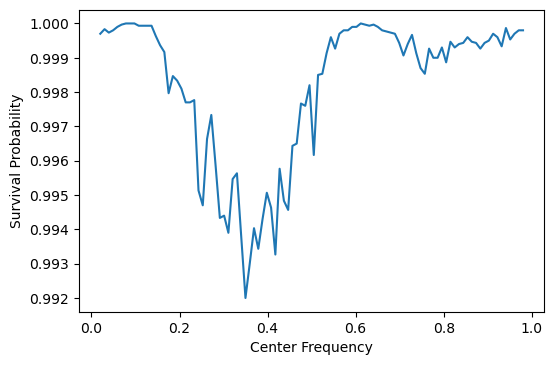

In [115]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(all_probs[:,0], all_probs[:,1])
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')

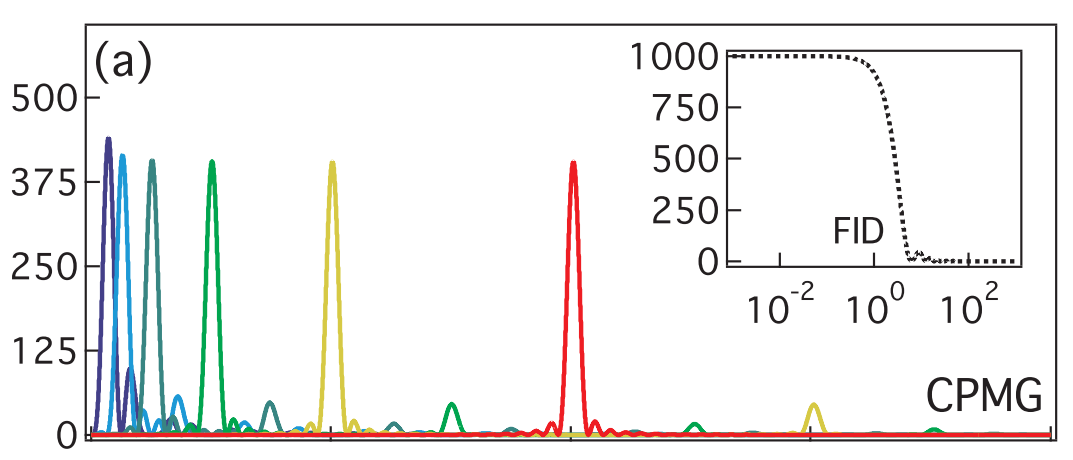

In [121]:
print(np.linspace(0.02, 0.98, num_center_freqs)[0])

0.02
